# ANALYSIS SENTIMEN PADA REVIEW UNTUK APLIKASI TRAVELOKA

INSTALL LIBRARY YANG DIGUNAKAN

In [ ]:
!pip install Sastrawi
!pip install vaderSentiment
!pip install wordcloud

IMPORT LIBRARY

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter

## DATA WRANGLING

UPLOAD DATA

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/mikti/Traveloka_reviews_v2.csv')
df

,username,feedback,score,at,app_version
0,Jarwi Siregar,"Layanan memuaskan, fitur lengkap.",4,2024-07-26 7:38:36,4.1.0
1,"Dr. Sarah Hasanah, M.Kom.",Udah nyoba berkali-kali tetep gk bisa.,2,2024-04-14 14:06:19,4.1.0
2,"Harsanto Susanti, S.IP",Udah nyoba berkali-kali tetep gk bisa.,2,2024-05-20 17:32:47,4.1.0
3,dr. Rachel Budiman,"Payah, gk bisa dipake sama sekali.",2,2024-09-28 10:43:45,4.1.0
4,Usyi Wijayanti,"Gak bisa checkout, tolong perbaiki dong!",3,2024-06-04 14:45:08,4.1.0
...,...,...,...,...,...
1995,"KH. Mustika Handayani, S.E.I","Pokoknya juara, the best dah.",4,2024-02-05 6:12:15,4.1.0
1996,Tgk. Olga Budiman,"App-nya keren, mantul!",5,2024-10-23 15:30:44,4.1.0
1997,"Drs. Wulan Hariyah, S.Gz","Cepat dan responsif, saya suka.",5,2024-07-31 2:36:43,4.1.0
1998,"Darman Pranowo, S.Gz","Mantap, semuanya lancar.",4,2024-04-18 18:02:03,4.1.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   username     2000 non-null   object
 1   feedback     1950 non-null   object
 2   score        2000 non-null   int64 
 3   at           2000 non-null   object
 4   app_version  2000 non-null   object
dtypes: int64(1), object(4)
memory usage: 78.2+ KB


In [ ]:
df.describe()

,score
count,2000.000000
mean,2.967500
std,1.392269
min,1.000000
25%,2.000000
50%,3.000000
75%,4.000000
max,5.000000


In [ ]:
df.isnull().sum()

,0
username,0
feedback,50
score,0
at,0
app_version,0


In [ ]:
df.duplicated().sum()

0

Terdapat 50 data NULL yang dimana akan dilakukan drop
Dan tidak ada data yang duplicated dari 1 dataset tersebut, tetapi pemeriksaan setiap kolom belum dilakukan

## Data Cleansing Dan Preprocessing

In [ ]:
# Menghapus nilai kosong
df = df.dropna().reset_index(drop=True)

In [ ]:
df.isnull().sum()

,0
username,0
feedback,0
score,0
at,0
app_version,0


Mengecek data duplicate di kolom 'feedback' yang dimana kolom ini merupakan kolom yang akan digunakan dalam melakukan sentiment anlysis

In [ ]:
df['feedback'].duplicated().sum()

1930

In [ ]:
df['feedback'].nunique()

20

In [ ]:
df['feedback'].unique()

array(['Layanan memuaskan, fitur lengkap.',
       'Udah nyoba berkali-kali tetep gk bisa.',
       'Payah, gk bisa dipake sama sekali.',
       'Gak bisa checkout, tolong perbaiki dong!',
       'Gagal terus, tolong dong diperbaiki!',
       'Aplikasinya suka ngelag parah', 'Sering eror, ga recommended.',
       'Cepat dan responsif, saya suka.',
       'Lancar jaya bro, gk ada error.',
       'Aduh app-nya error mulu, ga bener.',
       'Sipp, gk ada masalah, mantap.', 'Mantap, semuanya lancar.',
       'Pokoknya juara, the best dah.',
       'Mantul, pokoknya aplikasi ini juara deh!',
       'Lemot bgt app ini, fix uninstall.',
       'App ini mantap betul, gk kecewa.', 'Aplikasinya bagus banget!',
       'Lambat banget! ga enak dipake',
       'Males banget, tiap buka loading terus.', 'App-nya keren, mantul!'],
      dtype=object)

Dalam Kolom feed ternyata terdapat **1930** data duplicate dan hanya memiliki **20** nilai yang unik saja

Sehingga saya membuat 2 model yaitu
1. df2 = ketika duplicate pada kolom feedback tidak dihapus
2. df3 = ketika duplicate pada kolom feedback dihapus

### Melakukan Normalisasi  dan menghapus stopwords

In [ ]:
# Membuat dataset copy agar data asli tidak berubah
df_copy = df.copy()

In [ ]:
# Manipulasi membuat data menjadi lower
df_copy['feedback'] = df_copy['feedback'].str.lower()
df_copy['feedback']

,feedback
0,"layanan memuaskan, fitur lengkap."
1,udah nyoba berkali-kali tetep gk bisa.
2,udah nyoba berkali-kali tetep gk bisa.
3,"payah, gk bisa dipake sama sekali."
4,"gak bisa checkout, tolong perbaiki dong!"
...,...
1945,"pokoknya juara, the best dah."
1946,"app-nya keren, mantul!"
1947,"cepat dan responsif, saya suka."
1948,"mantap, semuanya lancar."


In [ ]:
# Melihat text yang memiliki angka didalamnya
df_copy['feedback'].str.contains('\d').sum()

0

In [ ]:
# Menghilangkan karakter yang tidak perlu seperti tanda baca
df_copy['feedback'] = df_copy['feedback'].str.replace('[^\w\s]', '', regex=True)
df_copy['feedback']

,feedback
0,layanan memuaskan fitur lengkap
1,udah nyoba berkalikali tetep gk bisa
2,udah nyoba berkalikali tetep gk bisa
3,payah gk bisa dipake sama sekali
4,gak bisa checkout tolong perbaiki dong
...,...
1945,pokoknya juara the best dah
1946,appnya keren mantul
1947,cepat dan responsif saya suka
1948,mantap semuanya lancar


Mengecek kata yang typo atau yang tidak sesuai KBBI

In [ ]:
# Melihat nilai/ data yang uniq di kolom 'feedback'
df_copy['feedback'].unique()

array(['layanan memuaskan fitur lengkap',
       'udah nyoba berkalikali tetep gk bisa',
       'payah gk bisa dipake sama sekali',
       'gak bisa checkout tolong perbaiki dong',
       'gagal terus tolong dong diperbaiki',
       'aplikasinya suka ngelag parah', 'sering eror ga recommended',
       'cepat dan responsif saya suka', 'lancar jaya bro gk ada error',
       'aduh appnya error mulu ga bener', 'sipp gk ada masalah mantap',
       'mantap semuanya lancar', 'pokoknya juara the best dah',
       'mantul pokoknya aplikasi ini juara deh',
       'lemot bgt app ini fix uninstall',
       'app ini mantap betul gk kecewa', 'aplikasinya bagus banget',
       'lambat banget ga enak dipake',
       'males banget tiap buka loading terus', 'appnya keren mantul'],
      dtype=object)

In [ ]:
import re
Replace_text = {
    "ga": "tidak",
    "best" : "baik",
    "lemot" :"lambat",
    "recommended" :"rekomendasi",
    "bgt" : "banget",
    'gak' : 'tidak',
    "udah": "sudah",
    "tetep": "tetap",
    "gk": "tidak",
    "error": "eror",
    'nyoba': 'coba',
    "mantul": "mantap",
  }
# Fungsi untuk mengganti kata sesuai Replace_text
def replace(str_text):
    for word, replacement in Replace_text.items():
        str_text = re.sub(r'\b' + re.escape(word) + r'\b', replacement, str_text)
    return str_text


df_copy['feedback'] = df_copy['feedback'].apply(lambda x : replace(x))
df_copy['feedback']

,feedback
0,layanan memuaskan fitur lengkap
1,sudah coba berkalikali tetap tidak bisa
2,sudah coba berkalikali tetap tidak bisa
3,payah tidak bisa dipake sama sekali
4,tidak bisa checkout tolong perbaiki dong
...,...
1945,pokoknya juara the baik dah
1946,appnya keren mantap
1947,cepat dan responsif saya suka
1948,mantap semuanya lancar


Menghapus stopwords (kata kata yang tidak digunakan atau tidak ada nilainya)

In [ ]:
# Download modul
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
add_drop_text =['dong','app-nya', 'app', 'mulu','bro','dah','deh']
stop_words = stopwords.words('indonesian') + stopwords.words('english') + add_drop_text
df_copy['feedback'] = df_copy['feedback'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
df_copy['feedback']

,feedback
0,layanan memuaskan fitur lengkap
1,coba berkalikali
2,coba berkalikali
3,payah dipake
4,checkout tolong perbaiki
...,...
1945,pokoknya juara
1946,appnya keren mantap
1947,cepat responsif suka
1948,mantap lancar


### Stemming / Lemmatization

stemming adalah proses untuk mengubah kalimat berimbuhan menjadi kalimat dasar

In [ ]:
stemmer = StemmerFactory().create_stemmer()
df_copy['feedback'] = df_copy['feedback'].apply(lambda x: " ".join([stemmer.stem(word) for word in x.split()]))
df_copy['feedback']

,feedback
0,layan muas fitur lengkap
1,coba berkalikali
2,coba berkalikali
3,payah dipake
4,checkout tolong baik
...,...
1945,pokok juara
1946,appnya keren mantap
1947,cepat responsif suka
1948,mantap lancar


In [ ]:
df_copy['feedback'].head(20)

,feedback
0,layan muas fitur lengkap
1,coba berkalikali
2,coba berkalikali
3,payah dipake
4,checkout tolong baik
5,gagal tolong baik
6,gagal tolong baik
7,aplikasi suka ngelag parah
8,checkout tolong baik
9,eror rekomendasi


In [ ]:
df_copy['feedback'].tail(20)

,feedback
1930,appnya keren mantap
1931,aplikasi bagus banget
1932,lambat banget enak dipake
1933,aplikasi suka ngelag parah
1934,males banget buka loading
1935,mantap kecewa
1936,aduh appnya eror bener
1937,aplikasi suka ngelag parah
1938,coba berkalikali
1939,appnya keren mantap


# Untuk Df2 (dataset yang duplicate pada kolom 'feedback' tidak dihapus)

### Visualisasi kemunculan data

In [ ]:
df2 = df_copy.copy()


In [ ]:
# Menghitung frekuensi kemunculan setiap kata
freq = pd.Series(' '.join(df2['feedback']).split()).value_counts()
head_freq=freq.head(20)
head_freq

,count
banget,431
mantap,379
eror,299
aplikasi,280
tolong,269
baik,269
dipake,260
lambat,240
appnya,196
suka,193


In [ ]:
# histrogram
fig = px.histogram(head_freq, x=head_freq.index, y=head_freq.values)
fig.update_layout(
    title="Total frekuensi kata",
    xaxis_title="Kata",
    yaxis_title="Jumlah kata"
)
fig.show()

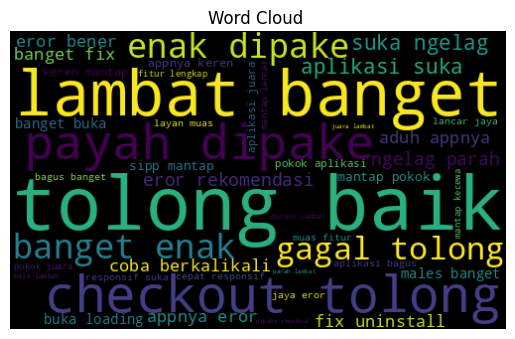

In [ ]:
all_words = ' '.join([i for i in df2['feedback']])
wordcloud = WordCloud(width=500, height=300, random_state=21, max_font_size=110).generate(all_words)

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Word Cloud ')
plt.show()

## Sentiment Analysis

Melakukan analysisi untuk mengelompokan apakah feedbacknya termasuk "positif" "negatif" atau "netral"

In [ ]:
analyzer = SentimentIntensityAnalyzer()

additional = {
    'rugi': -1,
    'buruk': -0.6,
    'jelek': -0.6,
    'lelet': -0.7,
    'gagal': -0.5,
    'parah': -0.6,
    'mahal': -0.3,
    'tolong': -0.1,
    'hilang': -0.3,
    'promo': 0.6,
    'ganggu': 0.3,
    'bagus': 0.5,
    'potong': -1,
    'baik': 0.5,
    'ngelag': -0.8,
    'salah': -0.5,
    'payah': -0.4,
    'benerin': -0.4,
    'lambat': -0.8,
    'mati': -0.7,
    'minimal': -0.3,
    'susah': -0.6,
    'capek': -0.7,
    'kacau': -0.3,
    'tagih': -0.3,
    'mantap': 0.7,
    'sulit': -0.6,
    'aneh': -0.4,
    'responsif' :0.6
}

analyzer.lexicon.update(additional)

df2['Sentiment'] =df2['feedback'].apply(lambda x: 'Positif' if analyzer.polarity_scores(x)['compound'] > 0 else ('Negatif' if analyzer.polarity_scores(x)['compound'] < 0 else 'Netral'))

df2

,username,feedback,score,at,app_version,Sentiment
0,Jarwi Siregar,layan muas fitur lengkap,4,2024-07-26 7:38:36,4.1.0,Netral
1,"Dr. Sarah Hasanah, M.Kom.",coba berkalikali,2,2024-04-14 14:06:19,4.1.0,Netral
2,"Harsanto Susanti, S.IP",coba berkalikali,2,2024-05-20 17:32:47,4.1.0,Netral
3,dr. Rachel Budiman,payah dipake,2,2024-09-28 10:43:45,4.1.0,Negatif
4,Usyi Wijayanti,checkout tolong baik,3,2024-06-04 14:45:08,4.1.0,Positif
...,...,...,...,...,...,...
1945,"KH. Mustika Handayani, S.E.I",pokok juara,4,2024-02-05 6:12:15,4.1.0,Netral
1946,Tgk. Olga Budiman,appnya keren mantap,5,2024-10-23 15:30:44,4.1.0,Positif
1947,"Drs. Wulan Hariyah, S.Gz",cepat responsif suka,5,2024-07-31 2:36:43,4.1.0,Positif
1948,"Darman Pranowo, S.Gz",mantap lancar,4,2024-04-18 18:02:03,4.1.0,Positif


Visualisasi

In [ ]:
# Distribusi label sentiment
temp = df2.groupby('Sentiment').count()['feedback'].reset_index().sort_values(by='feedback',ascending=False)
temp.style.background_gradient(cmap='viridis')

,Sentiment,feedback
2,Positif,681
1,Netral,657
0,Negatif,612


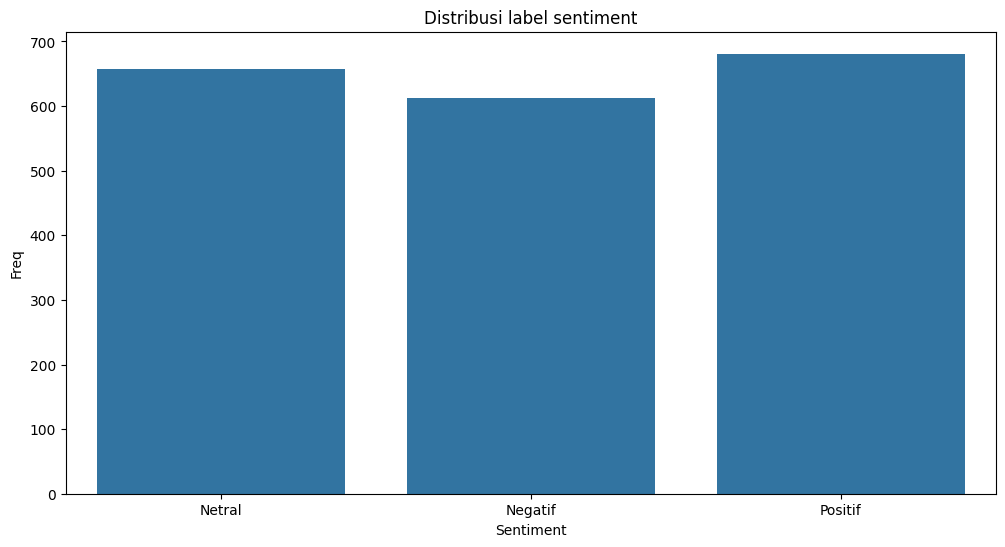

In [ ]:
plt.figure(figsize=(12,6))
sns.countplot(x='Sentiment',data=df2)
plt.title('Distribusi label sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Freq')
plt.show()

In [ ]:
# buat pie chart
fig = px.pie(temp, values='feedback', names='Sentiment', hole=0.5)
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

### Visualisasi setiap sentiment

**Persebaran Positif**

In [ ]:
df_postif = df2[df2['Sentiment'] == 'Positif']
TPostif = pd.Series(' '.join(df_postif['feedback']).split()).value_counts()
head_postif=TPostif.head(10)
head_postif

,count
mantap,379
aplikasi,163
checkout,146
baik,146
tolong,146
appnya,84
keren,84
sipp,84
pokok,83
juara,83


In [ ]:
# histrogram
fig_pos = px.histogram(head_postif, x=head_postif.index, y=head_postif.values)
fig_pos.update_layout(
    title="Total kata untuk sentimen Positif",
    xaxis_title="Kata",
    yaxis_title="Jumlah kata",
    width=1000,
    height=500
)
fig_pos.show()

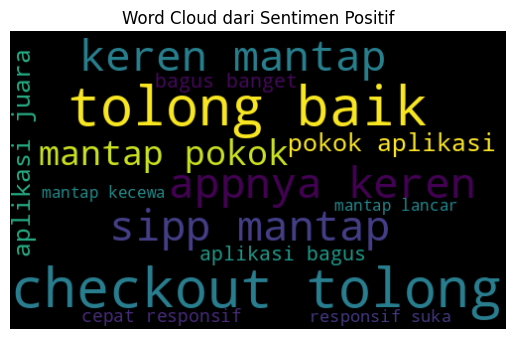

In [ ]:
all_words_positif = ' '.join([i for i in df_postif['feedback']])
wordcloud_positif = WordCloud(width=500, height=300, random_state=21, max_font_size=110).generate(all_words_positif)

plt.imshow(wordcloud_positif, interpolation="bilinear")
plt.axis('off')
plt.title('Word Cloud dari Sentimen Positif')
plt.show()

**Persebaran Negatif**

In [ ]:
df_neg = df2[df2['Sentiment'] == 'Negatif']
Tneg = pd.Series(' '.join(df_neg['feedback']).split()).value_counts()
head_neg=Tneg.head(10)
head_neg

,count
dipake,260
lambat,240
banget,240
payah,132
enak,128
gagal,123
tolong,123
baik,123
aplikasi,117
suka,117


In [ ]:
# histrogram
fig_neg = px.histogram(head_neg, x=head_neg.index, y=head_neg.values)
fig_neg.update_layout(
    title="Total kata untuk sentimen Negatif",
    xaxis_title="Kata",
    yaxis_title="Jumlah kata",
    width=1000,
    height=500
)
fig_neg.show()

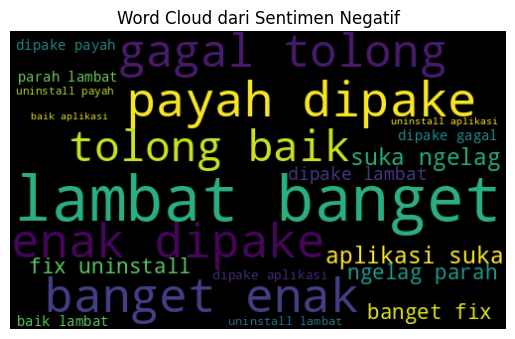

In [ ]:
all_words_negatif = ' '.join([i for i in df_neg['feedback']])
wordcloud_negatif = WordCloud(width=500, height=300, random_state=21, max_font_size=110).generate(all_words_negatif)

plt.imshow(wordcloud_negatif, interpolation="bilinear")
plt.axis('off')
plt.title('Word Cloud dari Sentimen Negatif')
plt.show()

**Penyebaran Netral**

In [ ]:
df_net = df2[df2['Sentiment'] == 'Netral']
Tnet = pd.Series(' '.join(df_net['feedback']).split()).value_counts()
head_net=Tnet.head(10)
head_net

,count
eror,299
rekomendasi,113
appnya,112
bener,112
aduh,112
loading,111
buka,111
banget,111
coba,111
berkalikali,111


In [ ]:
# histrogram
fig_net = px.histogram(head_net, x=head_net.index, y=head_net.values)
fig_net.update_layout(
    title="Total kata untuk sentimen Netral",
    xaxis_title="Kata",
    yaxis_title="Jumlah kata",
    width=1000,
    height=500
)
fig_net.show()

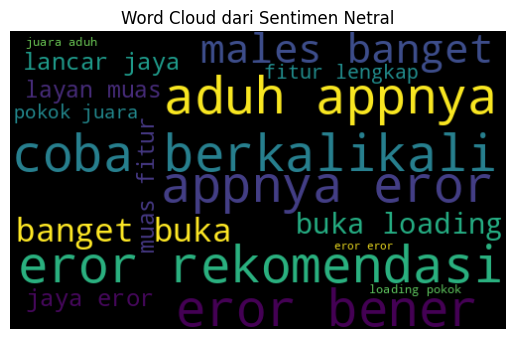

In [ ]:
all_words_net = ' '.join([i for i in df_net['feedback']])
wordcloud_net = WordCloud(width=500, height=300, random_state=21, max_font_size=110).generate(all_words_net)

plt.imshow(wordcloud_net, interpolation="bilinear")
plt.axis('off')
plt.title('Word Cloud dari Sentimen Netral')
plt.show()

## Vektorisasi

In [ ]:
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(df2['feedback'])
X_tfidf.toarray()

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.48374634, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [ ]:
df2

,username,feedback,score,at,app_version,Sentiment
0,Jarwi Siregar,layan muas fitur lengkap,4,2024-07-26 7:38:36,4.1.0,Netral
1,"Dr. Sarah Hasanah, M.Kom.",coba berkalikali,2,2024-04-14 14:06:19,4.1.0,Netral
2,"Harsanto Susanti, S.IP",coba berkalikali,2,2024-05-20 17:32:47,4.1.0,Netral
3,dr. Rachel Budiman,payah dipake,2,2024-09-28 10:43:45,4.1.0,Negatif
4,Usyi Wijayanti,checkout tolong baik,3,2024-06-04 14:45:08,4.1.0,Positif
...,...,...,...,...,...,...
1945,"KH. Mustika Handayani, S.E.I",pokok juara,4,2024-02-05 6:12:15,4.1.0,Netral
1946,Tgk. Olga Budiman,appnya keren mantap,5,2024-10-23 15:30:44,4.1.0,Positif
1947,"Drs. Wulan Hariyah, S.Gz",cepat responsif suka,5,2024-07-31 2:36:43,4.1.0,Positif
1948,"Darman Pranowo, S.Gz",mantap lancar,4,2024-04-18 18:02:03,4.1.0,Positif


## MODELLING

In [ ]:
# splitting
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, df2['Sentiment'], test_size=0.2, random_state=42)
X_train.shape, X_test.shape

((1560, 40), (390, 40))

In [ ]:
# menampilkan total dari netral, positif, dan negatif dari data train
y_train.value_counts()

,count
Sentiment,
Positif,539
Netral,529
Negatif,492


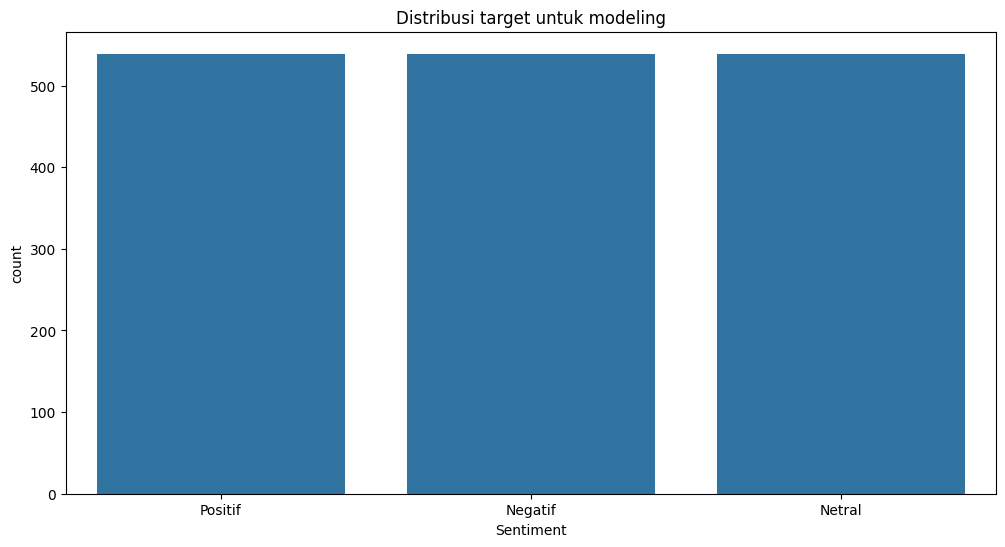

In [ ]:
# Resampling target agar data target seimbang

from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

plt.figure(figsize=(12, 6))
sns.countplot(x=y_train)
plt.title('Distribusi target untuk modeling')
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
# init parameters (tuning agar model semakin bagus)
rf_param_grid = {'n_estimators': [50, 100, 200],
                 'max_depth': [None, 10, 20, 30],
                 'min_samples_split': [2, 5, 10],
                 'min_samples_leaf': [1, 2, 4]}

In [ ]:
rf_model = RandomizedSearchCV(RandomForestClassifier(random_state=42), rf_param_grid, n_iter=10, cv=5, scoring='accuracy', random_state=42)
rf_model.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   param_distributions={'max_depth': [None, 10, 20, 30],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 200]},
                   random_state=42, scoring='accuracy')

In [ ]:
# evaluasi model
from sklearn.metrics import classification_report

y_pred_rf = rf_model.best_estimator_.predict(X_test)

print("\n\nClassification Report for Random Forest (Tuned):")
print(classification_report(y_test, y_pred_rf))



Classification Report for Random Forest (Tuned):
              precision    recall  f1-score   support

     Negatif       1.00      1.00      1.00       120
      Netral       1.00      1.00      1.00       128
     Positif       1.00      1.00      1.00       142

    accuracy                           1.00       390
   macro avg       1.00      1.00      1.00       390
weighted avg       1.00      1.00      1.00       390



## Percobaan

In [ ]:
# Text baru
text =["saya suka karena cepat dan memuaskan"]

# Melakukan vektorisasi dengan TF-IDF
text_vektor = tfidf_vectorizer.transform(text)
# Menggunakan model yang sudah dilatih untuk prediksi
prediction = rf_model.best_estimator_.predict(text_vektor)

# Hasil
print(f"Teks: {text}\nPrediksi Sentimen: {prediction}")

Teks: ['saya suka karena cepat dan memuaskan']
Prediksi Sentimen: ['Positif']


# df3 (KETIKA DUPLICATE PADA KOLOM FEEDBACK DIHAPUS )

In [ ]:
df3 = df2.copy().reset_index(drop=True)
df3

,username,feedback,score,at,app_version,Sentiment
0,Jarwi Siregar,layan muas fitur lengkap,4,2024-07-26 7:38:36,4.1.0,Netral
1,"Dr. Sarah Hasanah, M.Kom.",coba berkalikali,2,2024-04-14 14:06:19,4.1.0,Netral
2,"Harsanto Susanti, S.IP",coba berkalikali,2,2024-05-20 17:32:47,4.1.0,Netral
3,dr. Rachel Budiman,payah dipake,2,2024-09-28 10:43:45,4.1.0,Negatif
4,Usyi Wijayanti,checkout tolong baik,3,2024-06-04 14:45:08,4.1.0,Positif
...,...,...,...,...,...,...
1945,"KH. Mustika Handayani, S.E.I",pokok juara,4,2024-02-05 6:12:15,4.1.0,Netral
1946,Tgk. Olga Budiman,appnya keren mantap,5,2024-10-23 15:30:44,4.1.0,Positif
1947,"Drs. Wulan Hariyah, S.Gz",cepat responsif suka,5,2024-07-31 2:36:43,4.1.0,Positif
1948,"Darman Pranowo, S.Gz",mantap lancar,4,2024-04-18 18:02:03,4.1.0,Positif


In [ ]:
df3['feedback'].unique()

array(['layan muas fitur lengkap', 'coba berkalikali', 'payah dipake',
       'checkout tolong baik', 'gagal tolong baik',
       'aplikasi suka ngelag parah', 'eror rekomendasi',
       'cepat responsif suka', 'lancar jaya eror',
       'aduh appnya eror bener', 'sipp mantap', 'mantap lancar',
       'pokok juara', 'mantap pokok aplikasi juara',
       'lambat banget fix uninstall', 'mantap kecewa',
       'aplikasi bagus banget', 'lambat banget enak dipake',
       'males banget buka loading', 'appnya keren mantap'], dtype=object)

In [ ]:
# menghapus duplicate data pada kolom feedback
df3 = df3.drop_duplicates(subset='feedback').reset_index(drop=True)
df3

,username,feedback,score,at,app_version,Sentiment
0,Jarwi Siregar,layan muas fitur lengkap,4,2024-07-26 7:38:36,4.1.0,Netral
1,"Dr. Sarah Hasanah, M.Kom.",coba berkalikali,2,2024-04-14 14:06:19,4.1.0,Netral
2,dr. Rachel Budiman,payah dipake,2,2024-09-28 10:43:45,4.1.0,Negatif
3,Usyi Wijayanti,checkout tolong baik,3,2024-06-04 14:45:08,4.1.0,Positif
4,Lili Suryono,gagal tolong baik,2,2024-04-14 22:09:00,4.1.0,Negatif
5,Prayitna Suryono,aplikasi suka ngelag parah,2,2024-09-20 6:57:49,4.1.0,Negatif
6,Winda Sirait,eror rekomendasi,1,2024-09-16 7:04:42,4.1.0,Netral
7,"R.M. Kadir Susanti, S.Ked",cepat responsif suka,5,2024-09-19 10:04:43,4.1.0,Positif
8,Violet Wijaya,lancar jaya eror,4,2024-01-15 14:44:25,4.1.0,Netral
9,Alika Salahudin,aduh appnya eror bener,1,2024-09-09 8:00:59,4.1.0,Netral


In [ ]:
# Menghitung frekuensi kemunculan setiap kata
freq2 = pd.Series(' '.join(df3['feedback']).split()).value_counts()
head_freq2=freq2.head(10)
head_freq2

,count
mantap,5
banget,4
eror,3
aplikasi,3
lancar,2
pokok,2
juara,2
lambat,2
dipake,2
tolong,2


In [ ]:
# histrogram
fig2 = px.histogram(head_freq2, x=head_freq2.index, y=head_freq2.values)
fig2.update_layout(
    title="Total frekuensi kata",
    xaxis_title="Kata",
    yaxis_title="Jumlah kata",
    width=1000,
    height=500
)
fig2.show()

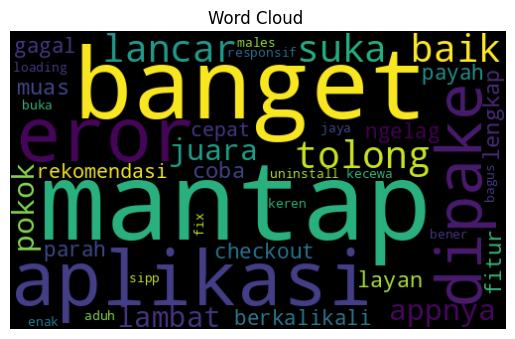

In [ ]:
all_words2 = ' '.join([i for i in df3['feedback']])
wordcloud2 = WordCloud(width=500, height=300, random_state=21, max_font_size=110).generate(all_words2)

plt.imshow(wordcloud2, interpolation="bilinear")
plt.axis('off')
plt.title('Word Cloud ')
plt.show()

In [ ]:
tfidf_vectorizer = TfidfVectorizer()
X_tfidf2 = tfidf_vectorizer.fit_transform(df3['feedback'])
X_tfidf2.toarray()

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.5       , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.5       ,
        0.5       , 0.        , 0.        , 0.        , 0.5       ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.70710678, 0.        , 0.        ,
        0.        , 0.70710678, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0. 

In [ ]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_tfidf2, df3['Sentiment'], test_size=0.15, random_state=42)
X_train2.shape, X_test2.shape

((17, 40), (3, 40))

In [ ]:
# menampilkan total dari netral, positif, dan negatif dari data train
y_train2.value_counts()

,count
Sentiment,
Positif,7
Netral,6
Negatif,4


In [ ]:
rf_model2 = RandomizedSearchCV(RandomForestClassifier(random_state=42), rf_param_grid, n_iter=10, cv=5, scoring='accuracy', random_state=42)
rf_model2.fit(X_train2, y_train2)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning:

invalid value encountered in cast



RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   param_distributions={'max_depth': [None, 10, 20, 30],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 200]},
                   random_state=42, scoring='accuracy')

In [ ]:
# evaluasi model
from sklearn.metrics import classification_report

y_pred_rf2 = rf_model2.best_estimator_.predict(X_test2)

print("\n\nClassification Report for Random Forest (Tuned):")
print(classification_report(y_test2, y_pred_rf2))



Classification Report for Random Forest (Tuned):
              precision    recall  f1-score   support

     Negatif       0.00      0.00      0.00         1
      Netral       0.00      0.00      0.00         1
     Positif       0.33      1.00      0.50         1

    accuracy                           0.33         3
   macro avg       0.11      0.33      0.17         3
weighted avg       0.11      0.33      0.17         3



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

